# Homework 1

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import cv2

import skimage.feature
import skimage.transform.hough_transform as ht

In [55]:
DEBUG = True
IMAGES_DIR = "./images_vol1"
VALID_FORMATS = (".jpg",".jpeg",".png")
RESIZED_IMG_SHAPE = (504, 378) # 4032x3024 -> :8
CANNY_EDGE_SIGMA = 2
# How many pixels "out-of-image" until a intersections still is considered reasonable
IMAGE_INTERSECTION_PADDING = 100

## Step 1: Function to read and preprocess images
Scale down, greyscale etc

In [3]:
def get_preprocessed_img(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, RESIZED_IMG_SHAPE)

    if img.shape[1] > img.shape[0]:
        img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)

    return img

In [4]:
def load_images():
    images = []
    if not os.path.isdir(IMAGES_DIR):
        raise Exception(f'{IMAGES_DIR} is not a directory - du pinsel')
    for f in os.listdir(IMAGES_DIR):
        if f.lower().endswith(VALID_FORMATS):
            images.append(get_preprocessed_img(os.path.join(IMAGES_DIR,f)))
    return images

## Step 2: Detect 4 edges
To determine where in the image the borders of the A4 sheet are

In [43]:
def get_edges(img):
    return skimage.feature.canny(img, sigma=CANNY_EDGE_SIGMA)

def get_top_n_lines(edges, n):
    lines = []
    H,angles,distances = ht.hough_line(edges)
    radii = np.arange(15,35)

    accum,angles,distances = ht.hough_line_peaks(
        H, angles, distances, threshold=10, min_distance=20, min_angle=15, num_peaks=n)

    for i in range(len(accum)):
        lines.append([distances[i],angles[i]])
    
    return lines

## Step 3: Calc intersections
Calculate intersections and check if they are reasonable (two "parallel" lines will also cross somewhere in nowhere out of the image scope)

In [21]:
# Calc 4 intersection coordinates given 4 lines
def get_sheet_corners(lines):
    intersections = []
    for i in range(len(lines)):
        lines_reduced = lines[:i] + lines[i+1:] 
        for l in lines_reduced:
            (x, y) = intersection(lines[i], l)
            if x > -IMAGE_INTERSECTION_PADDING and x < RESIZED_IMG_SHAPE[0] + IMAGE_INTERSECTION_PADDING and \
               y > -IMAGE_INTERSECTION_PADDING and y < RESIZED_IMG_SHAPE[1] + IMAGE_INTERSECTION_PADDING and \
               intersections.count([x,y]) == 0:
                intersections.append([x,y])
    return intersections

def intersection(line1, line2):
    rho1, theta1 = line1
    rho2, theta2 = line2

    A = np.array([
        [np.cos(theta1), np.sin(theta1)],
        [np.cos(theta2), np.sin(theta2)]
    ])
    b = np.array([rho1, rho2])

    # Solve A * [x, y] = b
    #print(A)
    #print(b)
    x, y = np.linalg.solve(A, b)
    return (x, y)

## Putting it all together :)

In [22]:
def plot_lines(ax, lines):
    for line in lines:
        d = line[0]
        theta = line[1]
        # This is one point on the line
        p1 = np.array([d*np.cos(theta), d*np.sin(theta)])
        # This is the unit vector pointing in the direction of the line (remember what theta means in Hough space!)
        linedir = np.array([np.cos(theta+np.pi/2), np.sin(theta+np.pi/2)])
        # These are two points very far away in two opposite directions along the line
        p0 = p1 - linedir * 1000 + IMAGE_INTERSECTION_PADDING
        p2 = p1 + linedir * 1000 + IMAGE_INTERSECTION_PADDING
        # We now draw a line through p0 and p2, without rescaling the axes.
        ax.plot([p0[0],p2[0]],[p0[1],p2[1]], scalex=False, scaley=False)

def plot_intersections(ax, points):
    for point in points:
        #print(point)
        ax.plot(point[0] + IMAGE_INTERSECTION_PADDING, point[1] + IMAGE_INTERSECTION_PADDING, marker="x", color="black")

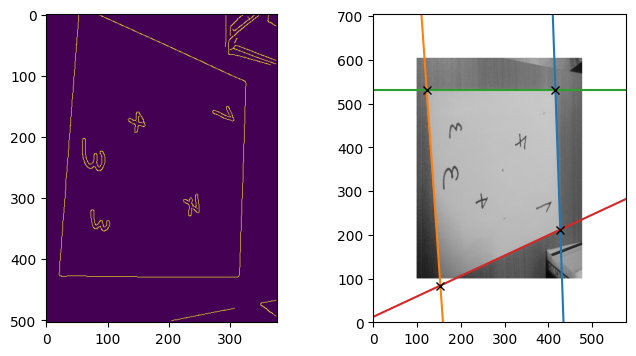

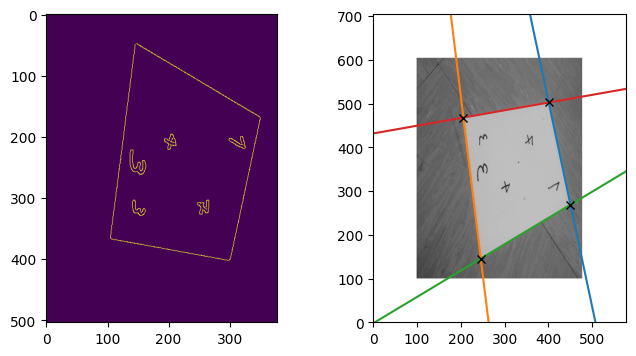

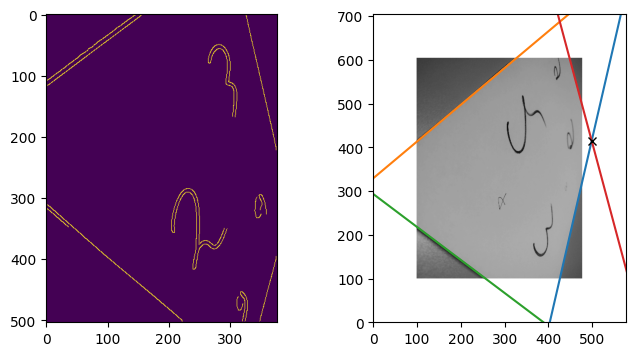

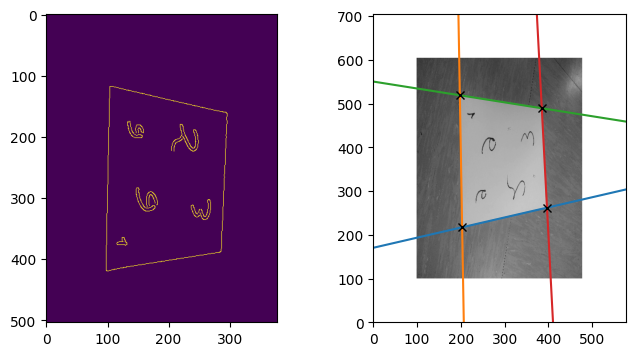

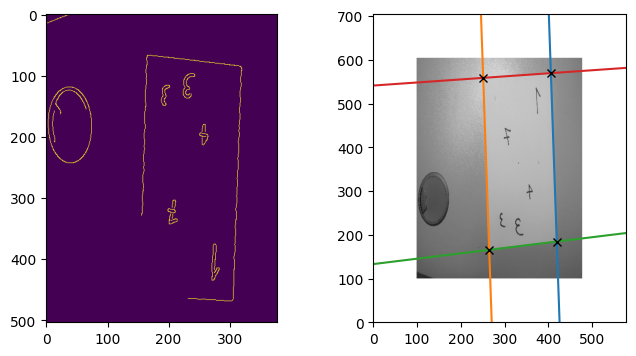

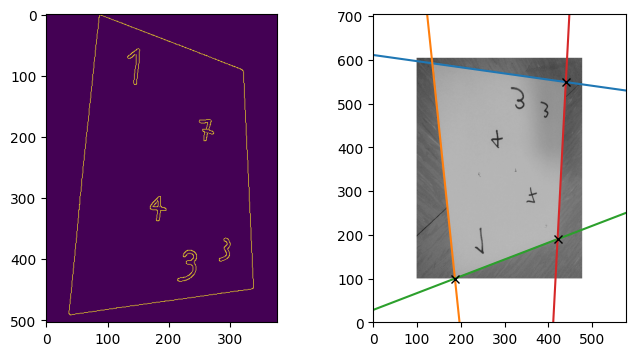

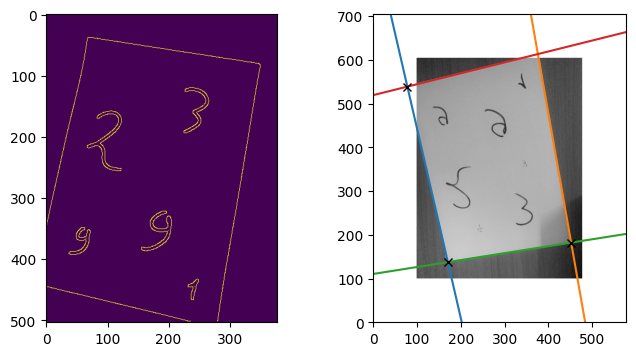

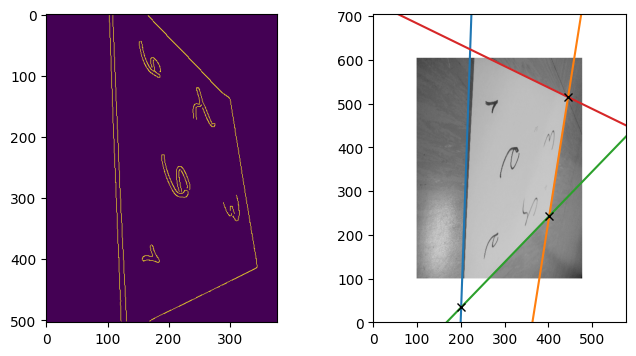

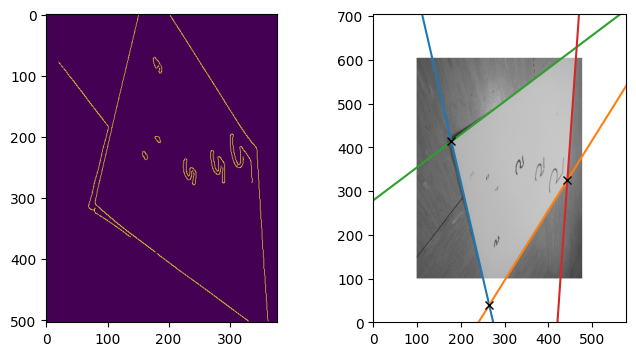

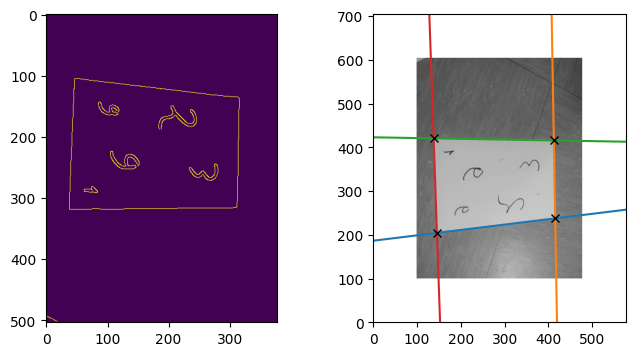

In [56]:
images = load_images()
for i in range(10):
    edges = get_edges(images[i])
    lines = get_top_n_lines(edges, 4)
    intersections = get_sheet_corners(lines)
    
    if DEBUG:
        fig,(ax0,ax1) = plt.subplots(ncols=2, nrows=1, figsize=(8,4))
        ax0.imshow(edges)
        img_padded = np.pad(images[i], pad_width=IMAGE_INTERSECTION_PADDING, mode='constant', constant_values=255)
        ax1.imshow(img_padded, cmap="gray")
        
        plot_lines(ax1, lines)
        plot_intersections(ax1, intersections)
        plt.xlim(0, RESIZED_IMG_SHAPE[1] + 2*IMAGE_INTERSECTION_PADDING)
        plt.ylim(0, RESIZED_IMG_SHAPE[0] + 2*IMAGE_INTERSECTION_PADDING)
        plt.show()